In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from generation.nets.abstract_net import AbstractGenerator, AbstractDiscriminator
from generation.config import SIGNAL_DIM, DETECTORS, POSTPROCESSED_SIGNALS_PATH

In [4]:
class MyDataset(Dataset):
    def __init__(self, detectors=DETECTORS, signal_dim=SIGNAL_DIM, freq=1):
        self.detectors = detectors
        self.signal_dim = signal_dim
        self.freq = freq
        
        self.signals = np.load(POSTPROCESSED_SIGNALS_PATH)       
        self.amplitudes = self._get_amplitudes()
        self.ref_times = self._get_ref_times()
        
    def _get_amplitudes(self):
        amplitudes = np.max(self.signals, axis=2)
        amplitudes /= np.max(amplitudes, axis=1)[:, None]
        return amplitudes
    
    def _get_ref_times(self):
        ref_times = np.zeros(self.amplitudes.shape)
        for detector_idx in range(ref_times.shape[0]):
            for signal_idx in range(ref_times.shape[1]):
                ref_times[detector_idx][signal_idx] = self._get_ref_time_pred(self.signals[detector_idx][signal_idx])
        np.nan_to_num(ref_times, 0)
        return ref_times
        
    @staticmethod
    def _get_ref_time_pred(signal):
        half_amplitude = np.min(signal) + (np.max(signal) - np.min(signal)) / 2
        for idx, cur_amplitude in enumerate(signal):
            if cur_amplitude > half_amplitude:
                return idx

    def __len__(self):
        return self.signals.shape[1]

    def __getitem__(self, idx):
        detector_times = self.ref_times[:, idx]
        detector_amplitudes = self.amplitudes[:, idx]
        
        features = np.concatenate([detector_times, detector_amplitudes], axis=0)
        
        tensor = torch.from_numpy(features)
        return tensor.float()


In [5]:
class Generator(AbstractGenerator):
    def __init__(self, config):
        super(Generator, self).__init__(config)
        self.x_dim = config['x_dim']
        self.z_dim = config['z_dim']
        
        self.final = nn.Sequential(
            nn.Linear(self.z_dim, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, self.x_dim),
            nn.ReLU()
        )
        
        
    def forward(self, x, debug=False):
        out = self.final(x)
        return out
        
        
    @staticmethod
    def get_rel_fake_fig(real_sample, fake_sample):
        real_sample = real_sample.cpu().data
        fake_sample = fake_sample.cpu().data

        plt.clf()
        fig, ax = plt.subplots(2, 2, figsize=(12, 12))
        ax[0][0].set_title("Real times")
        ax[0][0].plot(real_sample[:9])
        ax[0][1].set_title("Fake times")
        ax[0][1].plot(fake_sample[:9])
        ax[1][0].set_title("Real amplitudes")
        ax[1][0].plot(real_sample[9:])
        ax[1][1].set_title("Fake amplitudes")
        ax[1][1].plot(fake_sample[9:])
        return fig

In [6]:
from generation.inference import InferenceModel

In [9]:
model = InferenceModel(Generator, "3h49lzyf")

2021-02-27 17:42:07.400 | INFO     | generation.inference.inference_model:_load_checkpoint:25 - Restored checkpoint from epoch 998


In [37]:
samples_num = 1024

fake = model.generate(samples_num).cpu().numpy()

dataset = MyDataset()
idxs = np.random.choice(range(len(dataset)), samples_num)
real = [dataset[idx].numpy() for idx in idxs]

In [38]:
fake_times = np.array([item[:9] for item in fake])
fake_amplitudes = np.array([item[9:] for item in fake])

real_times = np.array([item[:9] for item in real])
real_amplitudes = np.array([item[9:] for item in real])

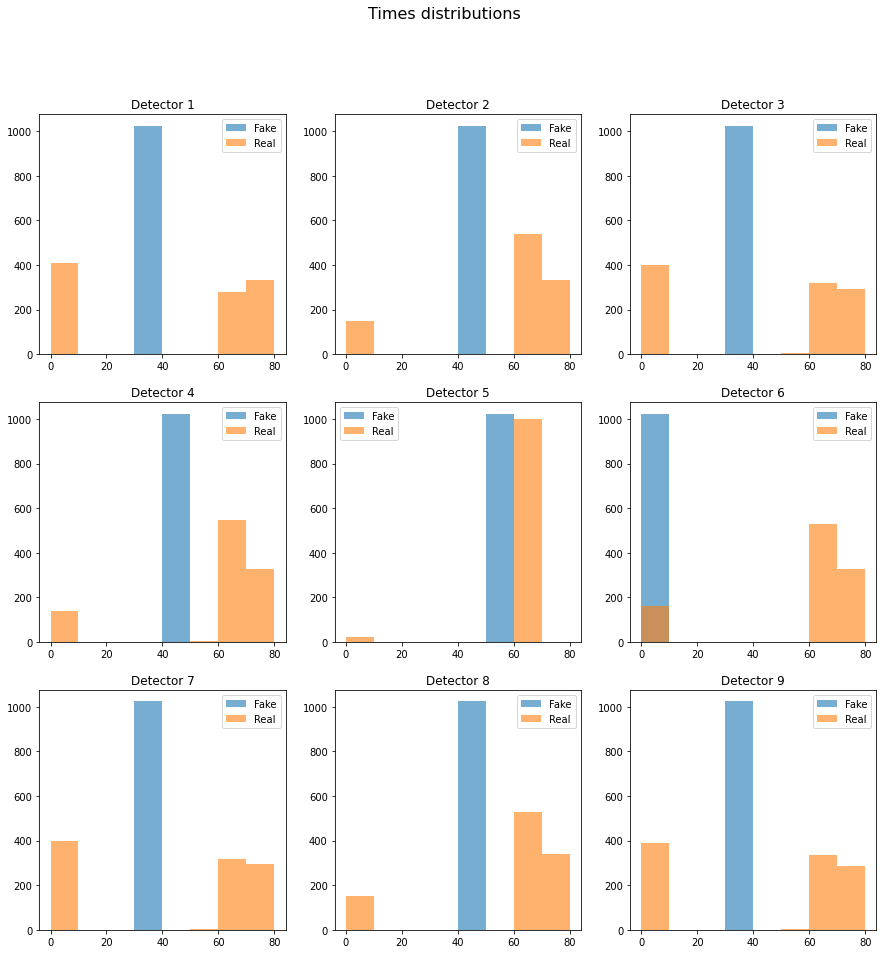

In [44]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("Times distributions", fontsize=16)

time_bins = [10 * x for x in range(9)]

for i in range(9):
    ax[i // 3][i % 3].set_title(f"Detector {i + 1}")
    ax[i // 3][i % 3].hist(fake_times[:, i], alpha=0.6, bins=time_bins)
    ax[i // 3][i % 3].hist(real_times[:, i], alpha=0.6, bins=time_bins)
    ax[i // 3][i % 3].legend(['Fake', 'Real'])

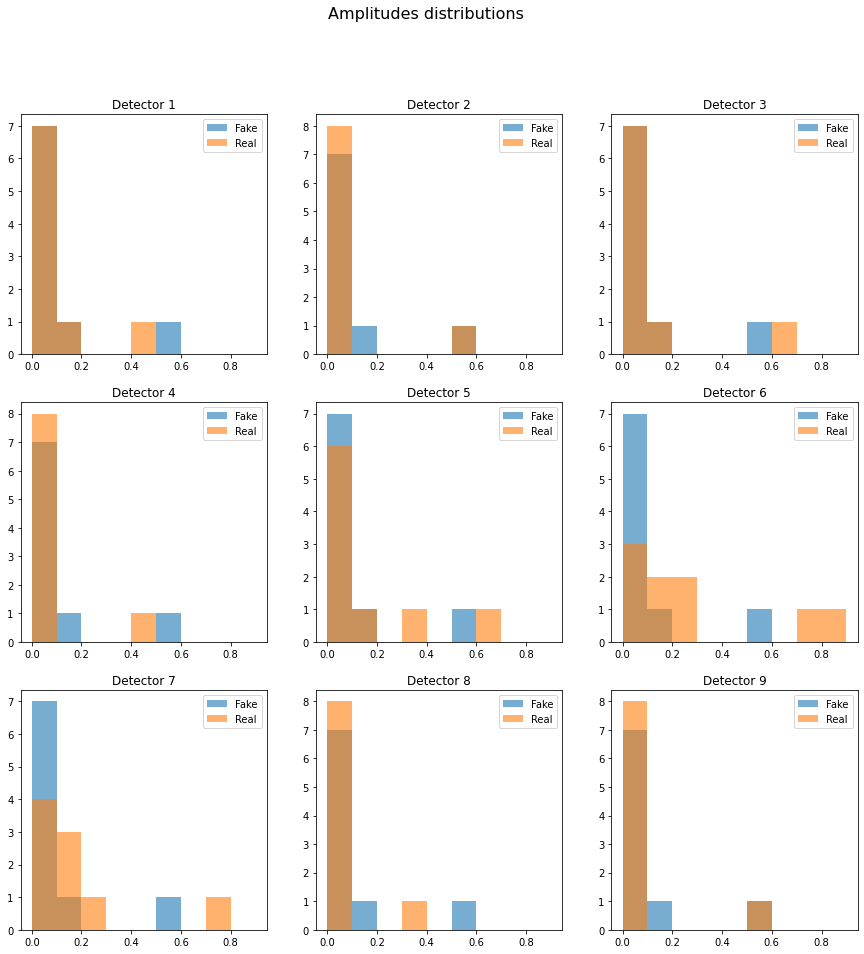

In [41]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("Amplitudes distributions", fontsize=16)

time_bins = [x for x in np.arange(0, 1, 0.1)]

for i in range(9):
    ax[i // 3][i % 3].set_title(f"Detector {i + 1}")
    ax[i // 3][i % 3].hist(fake_amplitudes[:, i], alpha=0.6, bins=time_bins)
    ax[i // 3][i % 3].hist(real_amplitudes[:, i], alpha=0.6, bins=time_bins)
    ax[i // 3][i % 3].legend(['Fake', 'Real'])